In [1]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

Autosaving every 150 seconds


# Load Data

In [2]:
def load_movielens_100k():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)

    # load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

def load_movielens_1M():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-1m/users.dat', sep='::', names=u_cols)

    # Load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

# Missing value treatment

In [3]:
from sklearn.impute import KNNImputer

def impute_missing_values(df, method="mean", **params):
    if method == "mean":
        return df.mean(), df.fillna(df.mean())
    elif method == "median":
        return df.median(), df.fillna(df.median())
    elif method == "KNN":
        knnimputer = KNNImputer(**params)
        knnimputer.fit(df)
        return knnimputer, knnimputer.transform(df)  

# Matrix Factorization based

In [4]:
data, users, ratings, movies = load_movielens_1M()

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:37: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


The DB has 1000209 ratings
The DB has  6040  users
The DB has  3706  movies
   user_id                                   title  movie_id  rating  \
0        1  One Flew Over the Cuckoo's Nest (1975)      1193       5   
1        2  One Flew Over the Cuckoo's Nest (1975)      1193       5   
2       12  One Flew Over the Cuckoo's Nest (1975)      1193       4   
3       15  One Flew Over the Cuckoo's Nest (1975)      1193       4   
4       17  One Flew Over the Cuckoo's Nest (1975)      1193       5   

  release_date  sex age  
0        Drama    1   F  
1        Drama   56   M  
2        Drama   25   M  
3        Drama   25   M  
4        Drama   50   M  


In [5]:
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
na_mask = user_item_matrix.isna().to_numpy()
imputer, imputed_uim = impute_missing_values(user_item_matrix, method="mean")

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

user_item_matrix_train = train.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix_test = test.pivot(index='user_id', columns='movie_id', values='rating')

In [7]:
u2idx = {u:idx for idx,u in enumerate(user_item_matrix.index.values)}
idx2u = {idx:u for idx,u in enumerate(user_item_matrix.index.values)}
i2idx = {i:idx for idx,i in enumerate(user_item_matrix.columns.values)} 
idx2i = {idx:i for idx,i in enumerate(user_item_matrix.columns.values)}

In [8]:
imputed_uim.shape

(6040, 3706)

### SVD missing value iteration

In [25]:
from scipy.linalg import svd

In [43]:
R_f = imputed_uim
U,s,Vt = svd(imputed_uim, full_matrices=False)
tmp = U.dot(np.diag(s)).dot(Vt)
R_f_1 = R_f.copy()
R_f_1[na_mask] = tmp

In [47]:
for i in range(10):
    R_f = R_f_1.copy()
    U,s,Vt = svd(R_f_1, full_matrices=False)
    tmp = U.dot(np.diag(s)).dot(Vt)
    R_f_1[na_mask] = tmp
    print(np.linalg.norm(R_f - R_f_1))

2.160528189879166e-11
2.14062854616419e-11
2.4900543836719436e-11
2.125893946197836e-11
2.2149406293781588e-11
2.3554143303590684e-11
2.165646015803868e-11
2.286399278977073e-11
2.2294015466695682e-11
2.1922060896382743e-11


### Classic SVD

In [9]:
from tqdm.notebook import tqdm

In [9]:
bu = np.load('saved/svd/bu.npy')
bi = np.load('saved/svd/bi.npy')
pu = np.load('saved/svd/pu.npy')
qi = np.load('saved/svd/qi.npy')
mu = user_item_matrix.mean().mean()

##### Naïve code

In [9]:
def compute_svd(user_item_matrix,
                init_mu = 0,
                init_sigma = 0.1,
                latent_dim = 200,
                n_epochs = 20,
                gamma = 0.007,
                lamb = 0.02):


    na_mask = np.isnan(user_item_matrix)

    #variables
    bu = np.zeros(user_item_matrix.shape[0])
    bi = np.zeros(user_item_matrix.shape[1])
    pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
    qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    mu = np.nanmean(user_item_matrix)


    # algorithm
    for epoch in range(n_epochs):
        for i in range(user_item_matrix.shape[1]):
            for u in np.where(~na_mask[:,i])[0]:
                r = user_item_matrix[u,i]

                err = r - (mu + bu[u] + bi[i] + np.dot(qi[i, :], pu[u,:].T))

                bu[u] += gamma*(err-lamb*bu[u])
                bi[i] += gamma*(err-lamb*bi[i])

                qi[i,:] += gamma*(err*pu[u,:] - lamb*qi[i,:])
                pu[u,:] += gamma*(err*qi[i,:] - lamb*pu[u,:])
    return bu, bi, pu, qi, mu

##### Cython
Let's try to improve it using cython

In [10]:
%load_ext cython

In [52]:
%%cython
cimport numpy as np
import numpy as np

def compute_svd_cython(double[:,:] user_item_matrix,
                 double init_mu=0, 
                 double init_sigma=0.1, 
                 int latent_dim=200, 
                 int n_epochs=20,
                 double gamma = 0.007,
                 double lamb = 0.02):

    na_mask = np.isnan(user_item_matrix)

    #variables
    bu = np.zeros(user_item_matrix.shape[0], np.double)
    bi = np.zeros(user_item_matrix.shape[1], np.double)
    pu = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[0], latent_dim))
    qi = np.random.normal(init_mu, init_sigma, (user_item_matrix.shape[1], latent_dim))
    cdef double mu = np.nanmean(user_item_matrix)

    cdef int i, u, epoch
    cdef double r = 0
    cdef double err = 0


    # algorithm
    for epoch in range(n_epochs):
        #print(str(epoch)+"/"+str(n_epochs))
        for i in range(user_item_matrix.shape[1]):
            for u in np.where(~na_mask[:,i])[0]:

                r = user_item_matrix[u,i]

                err = r - (mu + bu[u] + bi[i] + np.dot(qi[i, :], pu[u,:].T))

                bu[u] += gamma*(err-lamb*bu[u])
                bi[i] += gamma*(err-lamb*bi[i])

                qi[i,:] += gamma*(err*pu[u,:] - lamb*qi[i,:])
                pu[u,:] += gamma*(err*qi[i,:] - lamb*pu[u,:])
    return bu, bi, qi, pu, mu

##### Surprise

The `surprise` library has a better "cythonised" code for this.

In [81]:
import surprise
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

In [82]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [23]:
def compute_svd_surprise(data):
    algo = SVD(n_factors=200, n_epochs=1)
    algo.fit(data)

In [53]:
%timeit compute_svd(user_item_matrix, n_epochs=1)

14.8 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit compute_svd_cython(user_item_matrix, n_epochs=1)

12 s ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit compute_svd_surprise(trainset)

2.8 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Prediction

We will use surprise for the computation, but we will use our own predict function.

In [12]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD(n_factors=200, n_epochs=20)
algo.fit(trainset)

In [13]:
bu = algo.bu
bi = algo.bi
pu = algo.pu
qi = algo.qi
mu = user_item_matrix.mean().mean()

In [14]:
bu.shape, bi.shape, user_item_matrix.shape

((6040,), (3683,), (6040, 3706))

In [15]:
np.save('saved/svd/bu.npy', bu)
np.save('saved/svd/bi.npy', bi)
np.save('saved/svd/pu.npy', pu)
np.save('saved/svd/qi.npy', qi)

In [16]:
def predict(u, i):
    # This is a nuance of using train/test split. Since our dataset is split by surprise, let's use their functions
    uk = trainset.knows_user(u)
    ik = trainset.knows_item(i)
    
    r_hat = mu
    
    if uk:
        r_hat += bu[u]
    
    if ik: 
        r_hat += bi[i]
    
    if uk and ik:
        r_hat += np.dot(qi[i, :], pu[u,:].T)
    
    return r_hat

In [17]:
predict(10,2)

2.728968000743415

#### Rank Accuracy

In [83]:
to_test = [x[0:2] for x in testset if x[2] == 5.0]

In [43]:
def precision_at_N(N):
    hits = 0
    for u,i in to_test:
        candidate_unseen_movies = np.where(na_mask[u2idx[u],:])[0]
        candidate_unseen_movies = np.random.choice(candidate_unseen_movies, size=100, replace=False)
        candidate_unseen_movies = np.append(candidate_unseen_movies, i2idx[i])
        unseen_movies_order_idx = np.argsort([predict(u,idx2i[ii]) for ii in candidate_unseen_movies])[::-1]
        sorted_unseen_movies = candidate_unseen_movies[unseen_movies_order_idx]
        p = np.where(sorted_unseen_movies == i2idx[i])[0]
        hits += p<=N
    recall_N = hits/len(to_test)
    precision_N = recall_N/(N+1)
    return recall_N, precision_N

In [44]:
scores = []
for N in tqdm(range(1,21)):
    scores.append(precision_at_N(N))

prec = [x[1] for x in scores]
rec = [x[0] for x in scores]

[]

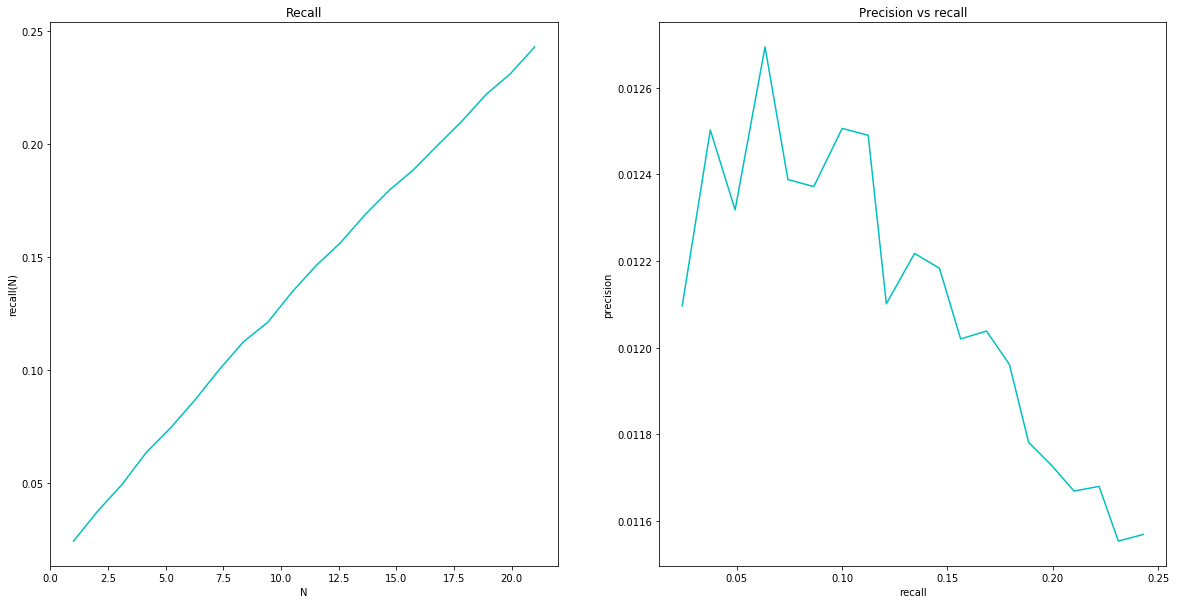

In [48]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
ax.plot(np.linspace(1,21,num=20), rec, 'c-')
ax.set_xlabel('N')
ax.set_ylabel('recall(N)')
ax.set_title('Recall')

ax = plt.subplot(1,2,2)
ax.plot(rec, prec, 'c-')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('Precision vs recall')

plt.plot()